In [17]:
import requests
import pandas as pd

# Your Alpha Vantage API key
api_key = "O8OQY6ET3RNZCAMK"

# Function to fetch data from Alpha Vantage
def fetch_alpha_vantage_data(function, symbol, api_key, outputsize='compact', additional_params={}):
    base_url = "https://www.alphavantage.co/query?"
    params = {
        'function': function,
        'symbol': symbol,
        'apikey': api_key,
        'outputsize': outputsize
    }
    params.update(additional_params)
    response = requests.get(base_url, params=params)
    data = response.json()
    return data

# Fetching quarterly earnings data for Tesla
income_statement_quarterly = fetch_alpha_vantage_data('INCOME_STATEMENT', 'TSLA', api_key)

# Fetching annual earnings data for Tesla
earnings_annual = fetch_alpha_vantage_data('EARNINGS', 'TSLA', api_key, additional_params={'datatype': 'csv'})

# Fetching daily stock price and volume data for Tesla (for the past year)
time_series_daily = fetch_alpha_vantage_data('TIME_SERIES_DAILY', 'TSLA', api_key)

# Fetching overview data for Tesla (includes shares outstanding)
overview = fetch_alpha_vantage_data('OVERVIEW', 'TSLA', api_key)

# Fetching institutional ownership data for Tesla (if available, might require a premium subscription)
# institutional_ownership = fetch_alpha_vantage_data('INSTITUTIONAL_OWNERSHIP', 'TSLA', api_key)

# Fetching daily data for S&P 500 index (for comparison)
sp500_daily = fetch_alpha_vantage_data('TIME_SERIES_DAILY', 'SPY', api_key) # SPY is a common ETF tracking the S&P 500

In [18]:
income_statement_quarterly = fetch_alpha_vantage_data('INCOME_STATEMENT', 'TSLA', api_key)


In [19]:
income_statement_quarterly_df = pd.DataFrame(income_statement_quarterly['quarterlyReports'])
income_statement_quarterly_df = income_statement_quarterly_df.set_index('fiscalDateEnding')
income_statement_quarterly_df.index = pd.to_datetime(income_statement_quarterly_df.index)
income_statement_quarterly_df['totalRevenue'] = pd.to_numeric(income_statement_quarterly_df['totalRevenue'])
income_statement_quarterly_df['netIncome'] = pd.to_numeric(income_statement_quarterly_df['netIncome'])

In [20]:
import io

# Processing quarterly earnings data
income_statement_quarterly_df = pd.DataFrame(income_statement_quarterly['quarterlyReports'])
income_statement_quarterly_df = income_statement_quarterly_df.set_index('fiscalDateEnding')
income_statement_quarterly_df.index = pd.to_datetime(income_statement_quarterly_df.index)
income_statement_quarterly_df['totalRevenue'] = pd.to_numeric(income_statement_quarterly_df['totalRevenue'])
income_statement_quarterly_df['netIncome'] = pd.to_numeric(income_statement_quarterly_df['netIncome'])


# Processing annual earnings data
if 'annualEarnings' in earnings_annual:
    earnings_annual_df = pd.DataFrame(earnings_annual['annualEarnings'])
    earnings_annual_df['fiscalDateEnding'] = pd.to_datetime(earnings_annual_df['fiscalDateEnding'])
    earnings_annual_df.set_index('fiscalDateEnding', inplace=True)
    earnings_annual_df['reportedEPS'] = pd.to_numeric(earnings_annual_df['reportedEPS'])
else:
    print("Error: No annual earnings data found in expected format.") 

# Processing daily stock price and volume data
time_series_daily_df = pd.DataFrame(time_series_daily['Time Series (Daily)']).T
time_series_daily_df.index = pd.to_datetime(time_series_daily_df.index)
time_series_daily_df['4. close'] = pd.to_numeric(time_series_daily_df['4. close'])
time_series_daily_df['5. volume'] = pd.to_numeric(time_series_daily_df['5. volume'])

# Extracting shares outstanding from overview data
shares_outstanding = int(float(overview['SharesOutstanding']))

# Processing S&P 500 daily data 
sp500_daily_df = pd.DataFrame(sp500_daily['Time Series (Daily)']).T
sp500_daily_df.index = pd.to_datetime(sp500_daily_df.index)
sp500_daily_df['4. close'] = pd.to_numeric(sp500_daily_df['4. close'])

In [16]:
# C: Current Quarterly Earnings and Sales
latest_quarter = earnings_quarterly_df.iloc[-1]
previous_year_quarter_data = earnings_quarterly_df[
    (earnings_quarterly_df.index.year == latest_quarter.name.year - 1) &
    (earnings_quarterly_df.index.quarter == latest_quarter.name.quarter)
]

if not previous_year_quarter_data.empty:
    previous_year_quarter = previous_year_quarter_data.iloc[0]
    eps_growth = ((latest_quarter['reportedEPS'] - previous_year_quarter['reportedEPS']) / previous_year_quarter['reportedEPS']) * 100

    latest_quarter_revenue = income_statement_quarterly_df.loc[latest_quarter.name, 'totalRevenue']
    previous_year_quarter_revenue = income_statement_quarterly_df.loc[previous_year_quarter.name, 'totalRevenue']
    sales_growth = ((latest_quarter_revenue - previous_year_quarter_revenue) / previous_year_quarter_revenue) * 100

    print(f"EPS Growth (Current Quarter): {eps_growth:.2f}%")
    print(f"Sales Growth (Current Quarter): {sales_growth:.2f}%")
else:
    print("No matching quarter found in the previous year for EPS and sales growth calculation.")

# A: Annual Earnings Growth
# Calculate year-over-year EPS growth for the past few years
earnings_annual_df['eps_growth'] = earnings_annual_df['reportedEPS'].pct_change() * 100

# Get user input for the number of recent years to consider
num_recent_years = int(input("Enter the number of recent years to consider for annual EPS growth (e.g., 3): "))

# Filter for the most recent years
recent_years = earnings_annual_df[
    earnings_annual_df.index >= pd.Timestamp.today().year - num_recent_years
]

# Check if there's enough data for annual growth analysis
if len(recent_years) >= 2:
    avg_annual_eps_growth = recent_years['eps_growth'].mean()
    print(f"Average Annual EPS Growth (Past {num_recent_years} years): {avg_annual_eps_growth:.2f}%")
else:
    print("Not enough annual earnings data for growth analysis.")

No matching quarter found in the previous year for EPS and sales growth calculation.
Enter the number of recent years to consider for annual EPS growth (e.g., 3): 3


TypeError: Invalid comparison between dtype=datetime64[ns] and int

## Leader/Laggard

In [18]:
# L: Leader or Laggard

# Calculate the percentage change in TSLA and S&P 500 over various timeframes
timeframes = [20, 50, 100]  # Consider 20-day, 50-day, 150-day, and 200-day timeframes

for timeframe in timeframes:
    tsla_pct_change = (
        (time_series_daily_df['4. close'][-1] - time_series_daily_df['4. close'][-timeframe]) 
        / time_series_daily_df['4. close'][-timeframe]
    ) * 100
    sp500_pct_change = (
        (sp500_daily_df['4. close'][-1] - sp500_daily_df['4. close'][-timeframe]) 
        / sp500_daily_df['4. close'][-timeframe]
    ) * 100

    relative_strength = tsla_pct_change - sp500_pct_change

    print(f"Relative Strength vs. S&P 500 ({timeframe}-day): {relative_strength:.2f}%")

Relative Strength vs. S&P 500 (20-day): -5.26%
Relative Strength vs. S&P 500 (50-day): -12.30%
Relative Strength vs. S&P 500 (100-day): -18.63%


## Market

In [19]:

sp500_daily_df['50_sma'] = sp500_daily_df['4. close'].rolling(window=50).mean()
sp500_daily_df['200_sma'] = sp500_daily_df['4. close'].rolling(window=200).mean()

# Assess market direction based on SMA relationships and recent price trend
if (sp500_daily_df['4. close'][-1] > sp500_daily_df['50_sma'][-1]) and (sp500_daily_df['50_sma'][-1] > sp500_daily_df['200_sma'][-1]):
    market_direction = "Strong Uptrend"
elif (sp500_daily_df['4. close'][-1] > sp500_daily_df['200_sma'][-1]):
    market_direction = "Uptrend"
elif (sp500_daily_df['4. close'][-1] < sp500_daily_df['200_sma'][-1]):
    market_direction = "Downtrend"
else:
    market_direction = "Sideways or Uncertain"

# Print the market direction assessment
print(f"Market Direction (based on S&P 500 50 & 200-day SMA): {market_direction}")

Market Direction (based on S&P 500 50 & 200-day SMA): Sideways or Uncertain


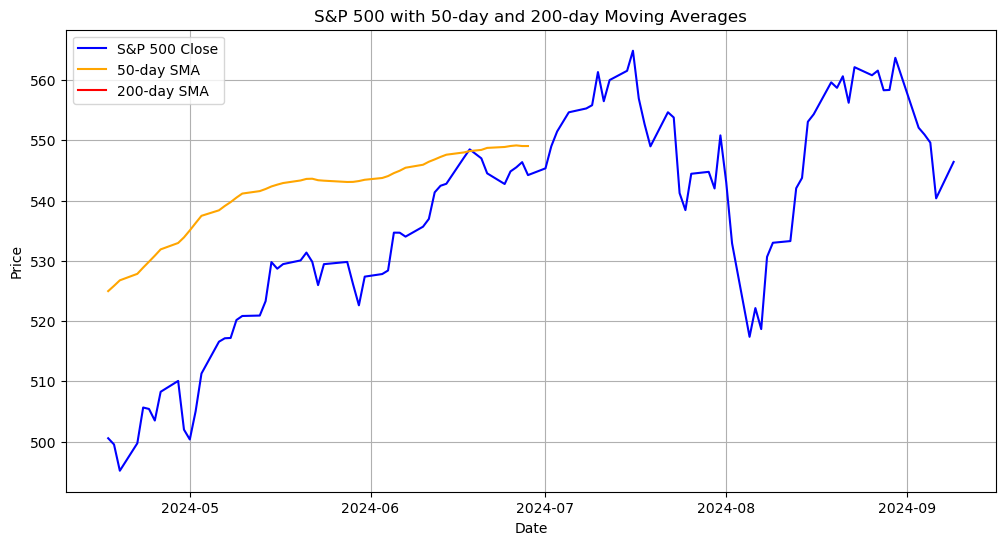

In [23]:
# M: Market Direction

# Calculate 50-day and 200-day simple moving averages (SMA) for S&P 500
sp500_daily_df['50_sma'] = sp500_daily_df['4. close'].rolling(window=50).mean()
sp500_daily_df['200_sma'] = sp500_daily_df['4. close'].rolling(window=200).mean()

# Plot the S&P 500 closing prices and moving averages
plt.figure(figsize=(12, 6))
plt.plot(sp500_daily_df.index, sp500_daily_df['4. close'], label='S&P 500 Close', color='blue')
plt.plot(sp500_daily_df.index, sp500_daily_df['50_sma'], label='50-day SMA', color='orange')
plt.plot(sp500_daily_df.index, sp500_daily_df['200_sma'], label='200-day SMA', color='red')
plt.title('S&P 500 with 50-day and 200-day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Assess market direction based on SMA relationships and recent price trend
# ... (Rest of your code for assessing market direction remains the same)

## Institutional 

In [2]:
import yfinance as yf

# ... (Rest of your existing code remains the same)

# Fetch institutional ownership data using yfinance
tsla_yf = yf.Ticker("TSLA")
major_holders = tsla_yf.major_holders

# Extract the percentage of shares held by institutions 
institutional_ownership_percentage = major_holders.iloc[2, 0]  # Assuming the 3rd row contains this information

# Print the result
print(f"Percentage of Institutional Ownership (from yfinance): {institutional_ownership_percentage}")

# ... (Rest of your code for calculating other CANSLIM metrics and applying filters)

Percentage of Institutional Ownership (from yfinance): 0.54127


/Users/lakshaya/anaconda3/lib/python3.11/site-packages/pandas/core/tools/datetimes.py:557: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)


In [3]:
major_holders

Breakdown,Value
insidersPercentHeld,0.12998
institutionsPercentHeld,0.47092
institutionsFloatPercentHeld,0.54127
institutionsCount,3764.00000


## Supply/Demand

In [6]:
import requests
import pandas as pd
import io

# Your Alpha Vantage API key
api_key = "JID9I465MYS961N1"

# Function to fetch data from Alpha Vantage
def fetch_alpha_vantage_data(function, symbol, api_key, outputsize='compact', additional_params={}):
    base_url = "https://www.alphavantage.co/query?"
    params = {
        'function': function,
        'symbol': symbol,
        'apikey': api_key,
        'outputsize': outputsize
    }
    params.update(additional_params)
    response = requests.get(base_url, params=params)
    data = response.json()
    return data

# ... (Fetching other data remains the same)

# Fetching intraday time series data for Tesla (using TIME_SERIES_INTRADAY)
time_series_intraday = fetch_alpha_vantage_data('TIME_SERIES_INTRADAY', 'TSLA', api_key, 
                                                additional_params={'interval': '60min'})  # You can adjust the interval as needed

# ... (Rest of your code remains the same)

# Processing intraday stock price and volume data
time_series_daily_df = pd.DataFrame(time_series_intraday['Time Series (60min)']).T  # Adjust the key if you change the interval
time_series_daily_df.index = pd.to_datetime(time_series_daily_df.index)
time_series_daily_df['4. close'] = pd.to_numeric(time_series_daily_df['4. close'])
time_series_daily_df['5. volume'] = pd.to_numeric(time_series_daily_df['5. volume'])

# ... (Rest of your code for processing and calculating other metrics)

In [21]:
# S: Supply and Demand

# ... (Supply calculation remains the same)

# Demand:

# 1. Calculate the average daily trading volume over the past month
trading_days_per_month = 20
trading_hours_per_day = 6.5
data_points_per_month = trading_days_per_month * trading_hours_per_day

# Adjust data_points_per_month if it exceeds the available data
data_points_per_month = min(data_points_per_month, len(time_series_daily_df))

avg_volume_past_month = time_series_daily_df['5. volume'][-data_points_per_month:].mean()

# 2. Calculate the percentage change in price over the past month
price_change_past_month = (
    (time_series_daily_df['4. close'][-1] - time_series_daily_df['4. close'][-data_points_per_month])
    / time_series_daily_df['4. close'][-data_points_per_month]
) * 100

# ... (Rest of the code for relative volume calculation and printing remains the same)
print(f"Shares Outstanding: {shares_outstanding}")
print(f"Average Volume (Past Month): {avg_volume_past_month:.0f}")
print(f"Price Change (Past Month): {price_change_past_month:.2f}%")
print(f"Relative Volume (Today): {relative_volume:.2f}")

Shares Outstanding: 3194640000
Average Volume (Past Month): 93818276
Price Change (Past Month): -28.12%
Relative Volume (Today): 0.97


## Current Quarterly earnings and sales

In [31]:
# ... (Rest of your code remains the same)

# Fetching quarterly income statement data for Tesla (includes revenue)
income_statement_quarterly = fetch_alpha_vantage_data('INCOME_STATEMENT', 'TSLA', api_key)

# ... (Rest of your data processing code remains the same)

# Processing quarterly income statement data
income_statement_quarterly_df = pd.DataFrame(income_statement_quarterly['quarterlyReports'])
income_statement_quarterly_df = income_statement_quarterly_df.set_index('fiscalDateEnding')
income_statement_quarterly_df.index = pd.to_datetime(income_statement_quarterly_df.index)
income_statement_quarterly_df['totalRevenue'] = pd.to_numeric(income_statement_quarterly_df['totalRevenue'])

# C: Current Quarterly Earnings and Sales

# Get the latest quarter's data
latest_quarter = earnings_quarterly_df.iloc[-1]

# Find the corresponding quarter from the previous year
previous_year_quarter = earnings_quarterly_df[
    (earnings_quarterly_df.index.year == latest_quarter.name.year - 1) & 
    (earnings_quarterly_df.index.quarter == latest_quarter.name.quarter)
]

if not previous_year_quarter.empty:
    previous_year_quarter = previous_year_quarter.iloc[0]

    # Calculate EPS growth
    eps_growth = ((latest_quarter['reportedEPS'] - previous_year_quarter['reportedEPS']) 
                  / previous_year_quarter['reportedEPS']) * 100

    # Calculate sales growth
    latest_quarter_revenue = income_statement_quarterly_df.loc[latest_quarter.name, 'totalRevenue']
    previous_year_quarter_revenue = income_statement_quarterly_df.loc[previous_year_quarter.name, 'totalRevenue']
    sales_growth = ((latest_quarter_revenue - previous_year_quarter_revenue) 
                    / previous_year_quarter_revenue) * 100

    # Print the calculated metrics
    print(f"EPS Growth (Current Quarter): {eps_growth:.2f}%")
    print(f"Sales Growth (Current Quarter): {sales_growth:.2f}%")

else:
    print("No matching quarter found in the previous year for EPS and sales growth calculation.")

No matching quarter found in the previous year for EPS and sales growth calculation.


In [44]:
earnings_quarterly_df

,reportedDate,reportedEPS,estimatedEPS,surprise,surprisePercentage,reportTime
fiscalDateEnding,,,,,,
2024-06-30,2024-07-23,0.5200,0.56,-0.04,-7.1429,post-market
2024-03-31,2024-04-23,0.4500,0.51,-0.06,-11.7647,post-market
2023-12-31,2024-01-24,0.7100,0.74,-0.03,-4.0541,post-market
2023-09-30,2023-10-18,0.6600,0.72,-0.06,-8.3333,post-market
2023-06-30,2023-07-19,0.9100,0.82,0.09,10.9756,post-market
2023-03-31,2023-04-19,0.8500,0.85,0,0,post-market
2022-12-31,2023-01-25,1.1900,1.13,0.06,5.3097,post-market
2022-09-30,2022-10-19,1.0500,0.99,0.06,6.0606,post-market
2022-06-30,2022-07-20,0.7600,0.6,0.16,26.6667,post-market


In [34]:
income_statement_quarterly

{'symbol': 'TSLA',
 'annualReports': [{'fiscalDateEnding': '2023-12-31',
   'reportedCurrency': 'USD',
   'grossProfit': '17660000000',
   'totalRevenue': '96773000000',
   'costOfRevenue': '79113000000',
   'costofGoodsAndServicesSold': '463000000',
   'operatingIncome': '8891000000',
   'sellingGeneralAndAdministrative': '4800000000',
   'researchAndDevelopment': '3969000000',
   'operatingExpenses': '8769000000',
   'investmentIncomeNet': '1066000000',
   'netInterestIncome': '-156000000',
   'interestIncome': '1066000000',
   'interestExpense': '156000000',
   'nonInterestIncome': '96917000000',
   'otherNonOperatingIncome': '172000000',
   'depreciation': '3330000000',
   'depreciationAndAmortization': '506000000',
   'incomeBeforeTax': '9996000000',
   'incomeTaxExpense': '-5001000000',
   'interestAndDebtExpense': '156000000',
   'netIncomeFromContinuingOperations': '14974000000',
   'comprehensiveIncomeNetOfTax': '15215000000',
   'ebit': '10152000000',
   'ebitda': '1065800000

In [35]:
income_statement_quarterly_df

,reportedCurrency,grossProfit,totalRevenue,costOfRevenue,costofGoodsAndServicesSold,operatingIncome,sellingGeneralAndAdministrative,researchAndDevelopment,operatingExpenses,investmentIncomeNet,...,depreciation,depreciationAndAmortization,incomeBeforeTax,incomeTaxExpense,interestAndDebtExpense,netIncomeFromContinuingOperations,comprehensiveIncomeNetOfTax,ebit,ebitda,netIncome
fiscalDateEnding,,,,,,,,,,,,,,,,,,,,,
2024-06-30,USD,4578000000,25500000000,20922000000,78000000,1605000000,1277000000,1074000000,2973000000,348000000,...,981000000,1278000000,1871000000,393000000,86000000,1494000000,1410000000,1957000000,3505000000,1478000000
2024-03-31,USD,3696000000,21301000000,17605000000,68000000,1171000000,1374000000,1151000000,2525000000,350000000,...,929000000,1246000000,1538000000,409000000,76000000,1144000000,873000000,1614000000,2417000000,1129000000
2023-12-31,USD,4438000000,25167000000,20729000000,102000000,2064000000,1280000000,1094000000,2374000000,333000000,...,890000000,1232000000,2176000000,-5752000000,61000000,7943000000,8477000000,2237000000,3484000000,7928000000
2023-09-30,USD,4178000000,23350000000,19172000000,11000000,1764000000,1253000000,1161000000,2414000000,282000000,...,897000000,1235000000,2020000000,167000000,38000000,1878000000,1571000000,2058000000,3318000000,1853000000
2023-06-30,USD,4533000000,24927000000,20394000000,57000000,2399000000,1191000000,943000000,2134000000,238000000,...,816000000,1154000000,3026000000,323000000,28000000,2614000000,2518000000,3054000000,3553000000,2703000000
2023-03-31,USD,4511000000,23329000000,18818000000,126000000,2664000000,1076000000,771000000,1847000000,213000000,...,722000000,1046000000,2774000000,261000000,29000000,2539000000,2649000000,2803000000,3710000000,2513000000
2022-12-31,USD,5777000000,24318000000,18541000000,143000000,3901000000,1032000000,810000000,1876000000,157000000,...,670000000,989000000,3963000000,276000000,33000000,3707000000,4268000000,3996000000,4890000000,3687000000
2022-09-30,USD,5382000000,21454000000,16072000000,97000000,3688000000,961000000,733000000,1694000000,86000000,...,620000000,956000000,3597000000,305000000,53000000,3331000000,2827000000,3650000000,4644000000,3292000000
2022-06-30,USD,4234000000,16934000000,12700000000,82000000,2464000000,961000000,667000000,1770000000,26000000,...,578000000,922000000,2464000000,205000000,44000000,2269000000,1832000000,2508000000,3386000000,2259000000


In [43]:
latest_quarter

reportedDate          2010-08-05
reportedEPS              -0.0271
estimatedEPS                None
surprise                    None
surprisePercentage          None
reportTime            pre-market
Name: 2010-06-30 00:00:00, dtype: object

## Annual

In [37]:
# A: Annual Earnings Growth

# Calculate year-over-year EPS growth
earnings_annual_df['eps_growth'] = earnings_annual_df['reportedEPS'].pct_change() * 100

# Filter for the most recent years (you can adjust the number of years as needed)
start_year = pd.Timestamp.today().year - num_years
recent_years = earnings_annual_df[earnings_annual_df.index >= pd.Timestamp(year=start_year, month=1, day=1)]  # Convert to datetime

# Check if there's enough data for annual growth analysis
if len(recent_years) >= 2:
    avg_annual_eps_growth = recent_years['eps_growth'].mean()
    print(f"Average Annual EPS Growth (Past {num_years} years): {avg_annual_eps_growth:.2f}%")
else:
    print("Not enough annual earnings data for growth analysis.")

Average Annual EPS Growth (Past 3 years): 69.41%


## New

In [38]:
import requests
from textblob import TextBlob

def get_news(api_key, query, page_size=20, page=1):
    url = 'https://newsapi.org/v2/everything'
    params = {
        'q': query,
        'pageSize': page_size,
        'page': page,
        'apiKey': api_key
    }
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        return None

def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

def main():
    api_key = '2838a16a77954c80a391b64716d14c55'  
    query = 'Tesla new product'  
    page_size = 20 
    page = 1 

    news_data = get_news(api_key, query, page_size, page)
    
    if news_data:
        articles = news_data.get('articles', [])
        overall_sentiment = 0
        for article in articles:
            title = article['title']
            description = article['description']
            content = title + ' ' + description if description else title
            sentiment_score = analyze_sentiment(content)
            overall_sentiment += sentiment_score
            sentiment = 'Positive' if sentiment_score > 0 else 'Negative' if sentiment_score < 0 else 'Neutral'
            print(f"Title: {title}")
            print(f"Description: {description}")
            print(f"Sentiment: {sentiment}")
            print(f"URL: {article['url']}") 
            print("-----")
        
        average_sentiment = overall_sentiment / len(articles) if articles else 0
        overall_sentiment_label = 'Positive' if average_sentiment > 0 else 'Negative' if average_sentiment < 0 else 'Neutral'
        print(f"Overall Sentiment: {overall_sentiment_label}")

if __name__ == "__main__":
    main()

Title: Here We Go Again: Elon Musk Reportedly Plans to Unveil Tesla Robotaxi at Warner Bros. Studios Lot
Description: Is it smart for Warner Bros. to associate with an extreme political figure like Musk?
Sentiment: Positive
URL: https://gizmodo.com/here-we-go-again-elon-musk-reportedly-plans-to-unveil-tesla-robotaxi-at-warner-bros-studios-lot-2000493561
-----
Title: Rivian is bringing Apple Music with spatial audio to its CarPlay-less EVs
Description: Rivian is pushing a new software update that includes Apple Music, but it requires a Connect Plus subscription to work on the go, while CarPlay is still not an option.
Sentiment: Positive
URL: https://www.theverge.com/2024/8/13/24218973/rivian-apple-music-connect-plus-subscribe-fee
-----
Title: Elon Musk’s Optimus Robot Debuts at World Robot Conference, Doesn’t Do Any Robot Things
Description: The World Robot Conference in Beijing was a marvelous exposition of our possible future and a showcase of how far Tesla's competitors have come.
Se

In [40]:
import requests
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def get_news(api_key, query, page_size=20, page=1):
    url = 'https://newsapi.org/v2/everything'
    params = {
        'q': query,
        'pageSize': page_size,
        'page': page,
        'apiKey': api_key
    }
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        return None

def analyze_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(text)
    return vs['compound']  # We'll use the compound score for overall sentiment

def main():
    api_key = '2838a16a77954c80a391b64716d14c55'  # Replace with your NewsAPI key
    query = 'Tesla new product'  # Modified query to focus on Tesla new products
    page_size = 20 
    page = 1 

    news_data = get_news(api_key, query, page_size, page)
    
    if news_data:
        articles = news_data.get('articles', [])
        overall_sentiment = 0
        for article in articles:
            title = article['title']
            description = article['description']
            content = title + ' ' + description if description else title
            sentiment_score = analyze_sentiment(content)
            overall_sentiment += sentiment_score
            sentiment = 'Positive' if sentiment_score >= 0.05 else 'Negative' if sentiment_score <= -0.05 else 'Neutral'
            print(f"Title: {title}")
            print(f"Description: {description}")
            print(f"Sentiment: {sentiment}")
            print(f"URL: {article['url']}") 
            print("-----")
        
        average_sentiment = overall_sentiment / len(articles) if articles else 0
        overall_sentiment_label = 'Positive' if average_sentiment > 0 else 'Negative' if average_sentiment < 0 else 'Neutral'
        print(f"Overall Sentiment for Tesla New Products: {overall_sentiment_label}")

if __name__ == "__main__":
    main()

Title: Here We Go Again: Elon Musk Reportedly Plans to Unveil Tesla Robotaxi at Warner Bros. Studios Lot
Description: Is it smart for Warner Bros. to associate with an extreme political figure like Musk?
Sentiment: Positive
URL: https://gizmodo.com/here-we-go-again-elon-musk-reportedly-plans-to-unveil-tesla-robotaxi-at-warner-bros-studios-lot-2000493561
-----
Title: Rivian is bringing Apple Music with spatial audio to its CarPlay-less EVs
Description: Rivian is pushing a new software update that includes Apple Music, but it requires a Connect Plus subscription to work on the go, while CarPlay is still not an option.
Sentiment: Neutral
URL: https://www.theverge.com/2024/8/13/24218973/rivian-apple-music-connect-plus-subscribe-fee
-----
Title: Elon Musk’s Optimus Robot Debuts at World Robot Conference, Doesn’t Do Any Robot Things
Description: The World Robot Conference in Beijing was a marvelous exposition of our possible future and a showcase of how far Tesla's competitors have come.
Sen

In [41]:
# N: New Products, Management, New Highs

# ... (Your existing code for fetching and processing data)

# Calculate 52-week high
fifty_two_week_high = time_series_daily_df['4. close'][-252:].max()

# Check for new highs
current_price = time_series_daily_df['4. close'][-1]
new_highs = current_price > fifty_two_week_high

# Print the result
if new_highs:
    print("Tesla's stock is making new 52-week highs!")
else:
    print("Tesla's stock is not making new 52-week highs.")

Tesla's stock is not making new 52-week highs.
